In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from typing import List, Tuple

In [2]:
recording = "rec.mp3"
output_file = "transcription.txt"

## Setting up a pipeline

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
    return_timestamps=True,
    generate_kwargs={"language": "russian"},
)

Device set to use cuda:0


## Extracting data from the recording

### Getting the transcripton and writing it to .txt

In [5]:
result = pipe(recording)

with open("transcription.txt", "w") as f:
    for line in result["chunks"]:
        f.write(f"{line['timestamp']}: {line['text']} \n")

/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed language=russian, but also have set `forced_decoder_ids` to [[1, None], [2, 50360]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of language=russian.


### Creating a preprocessed text without stowpords

In [6]:
nltk.download("stopwords")

stopwords = set(stopwords.words("russian"))


def preproc_nltk(text):
    return " ".join([word for word in text.split() if word not in stopwords])

[nltk_data] Downloading package stopwords to /home/usr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
preproc_text = preproc_nltk(result["text"])

### Extracting information about how many words were spoken by the certain time

In [8]:
seconds = [0]
words_counter = [0]
previous_end = 0
for line in result["chunks"]:
    start, end = line["timestamp"]
    text = line["text"]
    if end >= previous_end:
        seconds.append(seconds[-1] + end - previous_end)
    else:
        seconds.append(seconds[-1] + 30 - previous_end)
    words_counter.append(words_counter[-1] + len(text.split()))
    previous_end = end

### Calculating derivative (shows the spead of speech) and smoothing the obtained data using gaussian smoothing

In [9]:
def gaussian_smoothing(myarray: np.ndarray, degree=5):
    myarray = np.pad(myarray, (degree - 1, degree - 1), mode="edge")
    window = degree * 2 - 1

    weight = np.arange(-degree + 1, degree) / window
    weight = np.exp(-(16 * weight**2))
    weight /= weight.sum()

    smoothed = np.convolve(myarray, weight, mode="valid")
    return smoothed

In [10]:
words_per_second = np.gradient(words_counter, seconds)
words_per_second[words_per_second >= 7] = 7
words_per_second = np.nan_to_num(words_per_second, nan=np.nanmean(words_per_second))
words_per_second = gaussian_smoothing(words_per_second, degree=20)

/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1239: RuntimeWarning: invalid value encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/usr/miniforge3/envs/audio/lib/python3.10/site-packages/numpy/lib/function_base.py:1241: RuntimeWarn

### Calculating basic staistics

In [27]:
def calculate_statistics(
    speed_of_speech: np.ndarray, timestamps: List[int]
) -> Tuple[int]:
    average_speed = np.mean(speed_of_speech)
    max_speed = np.max(speed_of_speech)
    fastest_period = timestamps[np.argmax(words_per_second)]

    return average_speed, max_speed, fastest_period

## Showing the results

In [12]:
print(
    f"Yor text contains {int((1 - (len(preproc_text.split()) / len(result['text'].split()))) * 100)}% of stopwords"
)

Yor text contains 33% of stopwords


In [34]:
average_speed, max_speed, fastest_period = calculate_statistics(
    words_per_second, seconds
)

print(
    f"Average speed of speech: {average_speed:.3} wps",
    f"Max speed of seech: {max_speed:.3} wps",
    f"When was speech the fastest: {int(fastest_period)} s",
    sep="\n"
)

Average speed of speech: 1.96 wps
Max speed of seech: 2.55 wps
When was speech the fastest: 212 s


In [26]:
np.argmax(words_per_second)

38

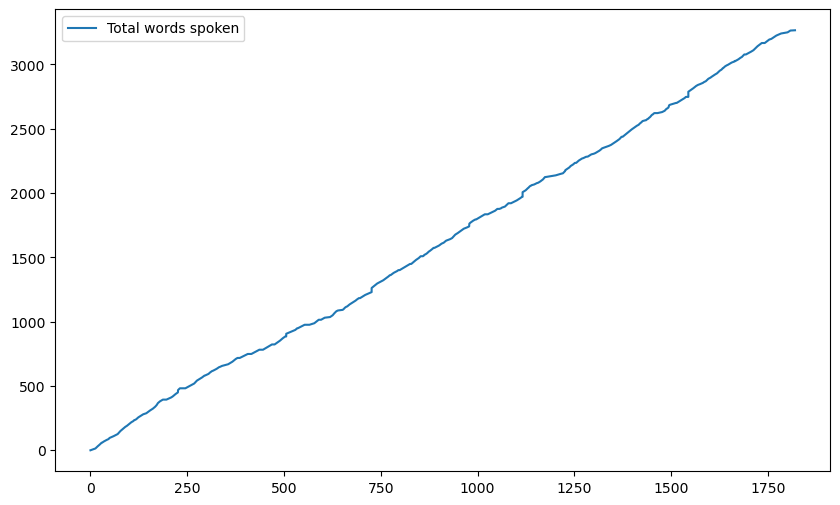

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(seconds, words_counter, label="Total words spoken")
plt.legend()
plt.show()

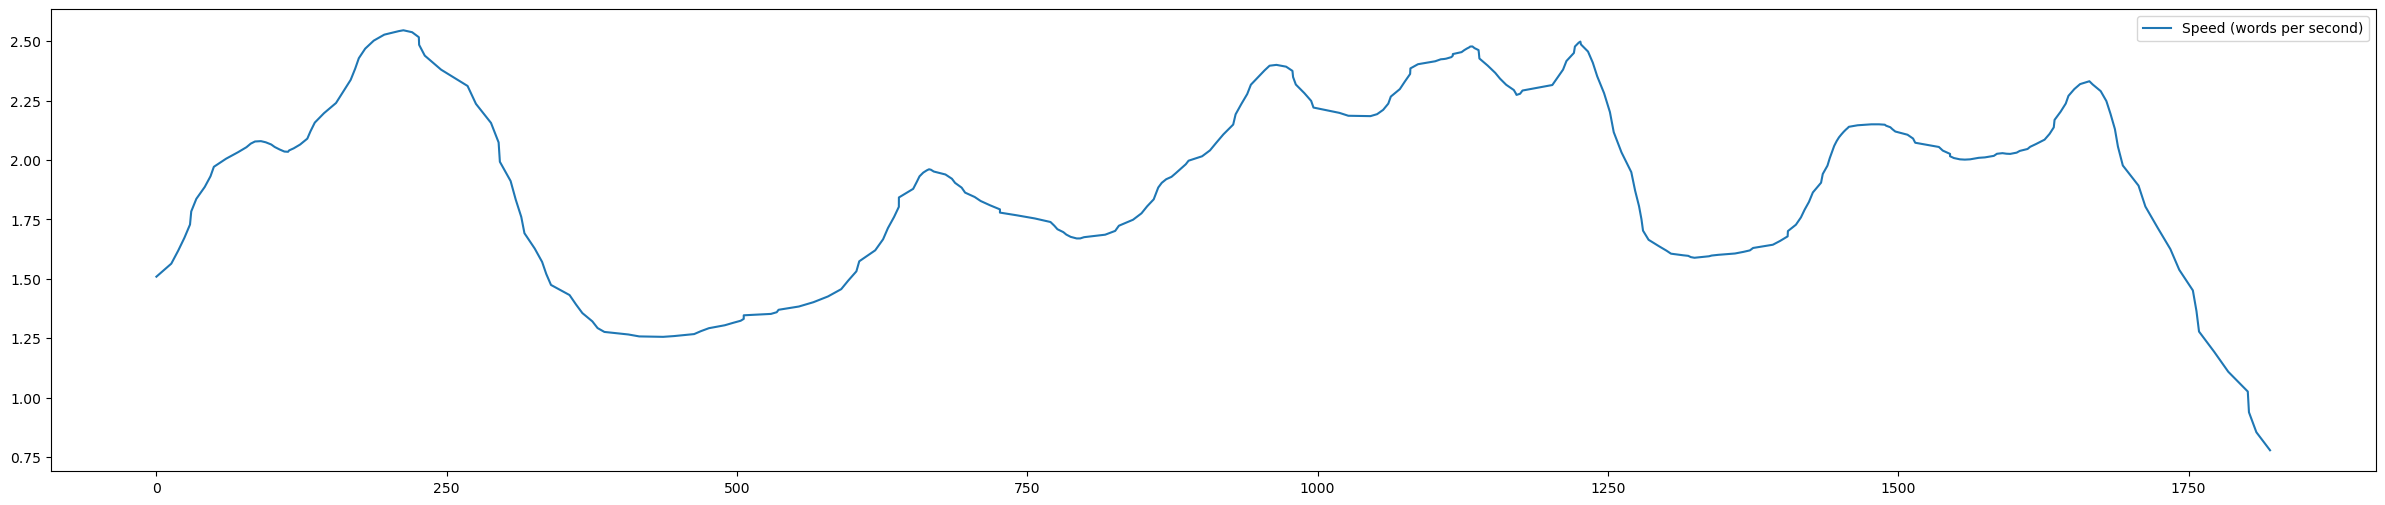

In [18]:
plt.figure(figsize=(30, 6))
plt.plot(seconds, words_per_second, label="Speed (words per second)")
plt.legend()
plt.show()

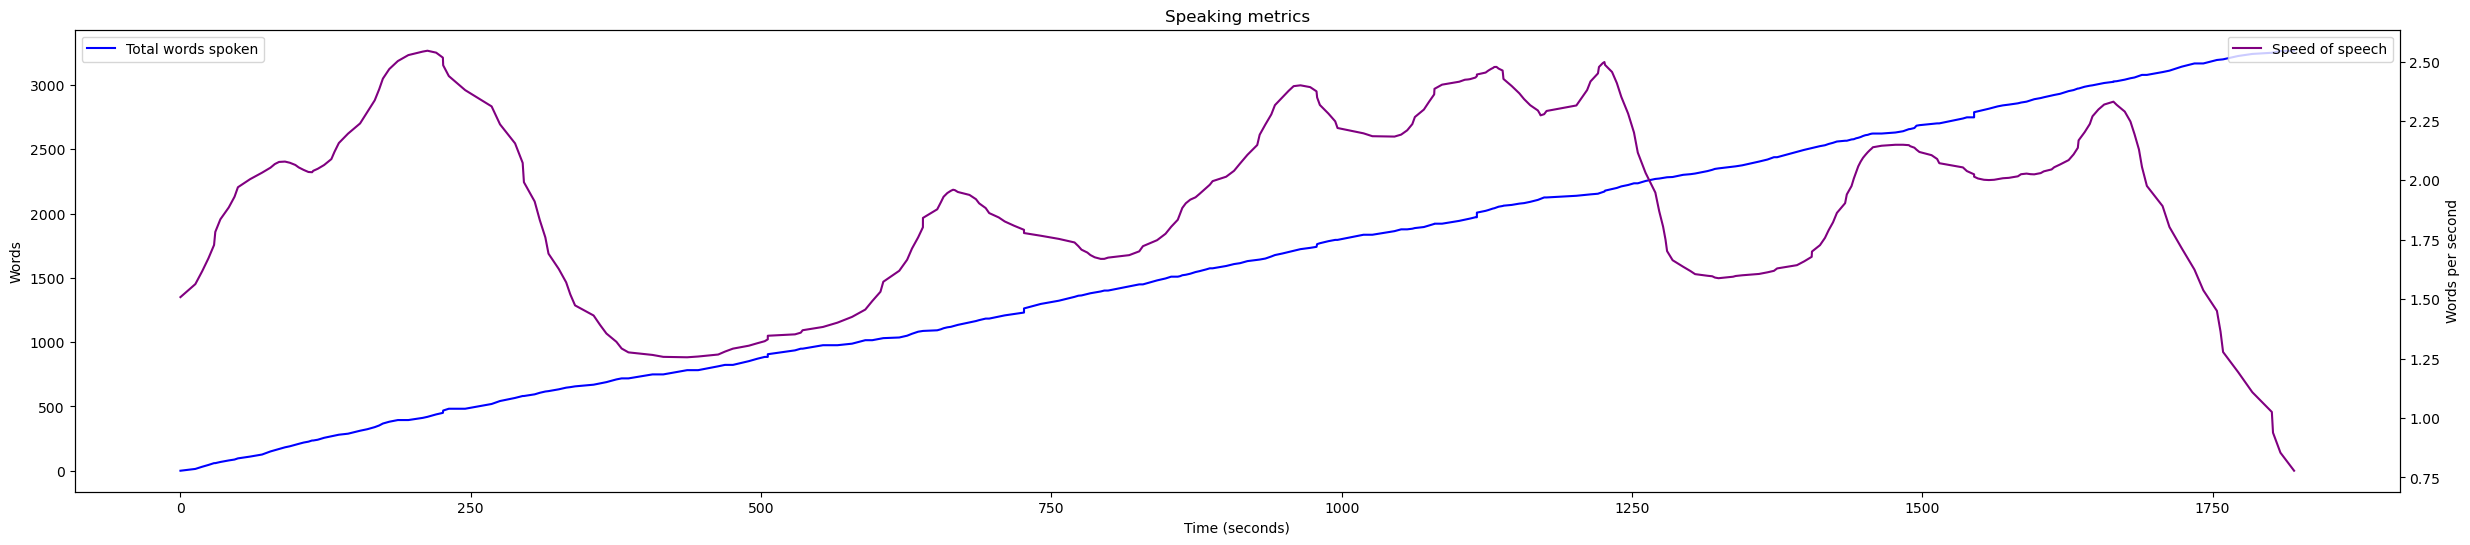

In [19]:
plt.figure(figsize=(30, 6))
plt.title("Speaking metrics")

plt.plot(seconds, words_counter, color="blue", label="Total words spoken")
plt.ylabel("Words")
plt.xlabel("Time (seconds)")
plt.xticks()
plt.legend(loc="upper left")

ax2 = plt.gca().twinx()

plt.plot(seconds, words_per_second, color="purple", label="Speed of speech")
plt.ylabel("Words per second")
plt.legend(loc="upper right")
plt.show()